***
<center><h1>Face Rhythm</h1></center>

***

<table><tr>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614723283221-5Z5038AT7Y6KCOM2PIU4/Screenshot+from+2021-03-02+17-05-12.png?content-type=image%2Fpng" style="height: 200px"> </td>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614723856628-J89PYYSF7K7JATE2KMF9/Screenshot+from+2021-03-02+17-23-46.png?format=300w&content-type=image%2Fpng" style="height: 200px"> </td>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614723931026-OORV0RAPZNWV3R8TBOXB/Screenshot+from+2021-03-02+17-25-11.png?format=300w&content-type=image%2Fpng" style="height: 200px"> </td>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614724055033-O3GBEF1D9MULFZKI2IUJ/Screenshot+from+2021-03-02+17-27-10.png?format=300w&content-type=image%2Fpng" style="height: 200px"> </td>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614723378405-WXN74ZTT1KYZUQGDM07X/face_rhythm_banner2.png?format=1000w&content-type=image%2Fpng" style="height: 200px"> </td>
</tr></table>

***

##### Notebook Shortcuts
- **[Notebook Setup](#Notebook-Setup)**: Prepare all the necessary config files and folders
- **[Set ROI](#Set-ROI)**: Set the ROI for the analysis
- **[Run Optic Flow](#Run-Optic-Flow)**: Run the optic flow analysis
- **[Clean Optic Flow](#Clean-Optic-Flow)**: Optic flow post-processing
- **[Convolutional Dimensionality Reduction](#Convolutional-Dimensionality-Reduction)**: Convolutional Dimensionality Reduction
- **[Analysis](#Analysis)**: Decompose and Analyze the optic flow data in many ways
- **[Comparisons](#Comparisons)**: Compare Face Rhythm to some peer algorithms

***

# Tips on running this notebook:
In theory it would be nice if you could just enter the path of the video(s) and just let it run all the way through. In practice, there are a few hoops to jump through
- Run the Notebook Setup Block (two blocks below this one). This should pretty much always be done, even if you are loading precomputed file from disk instead of calculating them. This step loads in some useful meta data used throughout.
- Even if you are restarting at a specific point in your analysis, run your Setup Block then head down to your current analysis step cell 

# Project Directory Organization
------------

    Project Directory
    ├── config.yaml           <- Configuration parameters to run each module in the pipeline. Dictionary.
    ├── run_info.json         <- Output information from each module. Dictionary.
    │
    ├── run_data              <- Output data from each module.
    │   ├── Dataset_videos.h5 <- Output data from Dataset_videos class. Contains metadata about the videos.
    │   ├── ROIs.h5           <- Output data from ROIs class. Contains ROI masks.
    │   ├── PointTracker.h5   <- Output data from PointTracker class. Contains point tracking data.
    |   ├── VQT_Analyzer.h5   <- Output data from VQT_Analyzer class. Contains spectral decomposition data.
    │   ├── TCA.h5            <- Output data from TCA class. Contains TCA decomposition data.
    │   
    └── visualizations        <- Output visualizations.
        ├── factors_rearranged_[frequency].png  <- Example of a rearranged factor plot.
        └── point_tracking_demo.avi             <- Example video.



***
<center><h1>Notebook Setup</h1></center>

***

### Creates config and locates videos

**Crucially, always run this first cell every time you run this notebook.**

Also, generally make sure to read through the config parameters before running.

The Project path is the path to a folder (existing or not) where we will store our derived files. I recommend creating a project folder and then copying this notebook into that folder.
The Video path is the path to a folder containing videos. 
The run name will determine the name of the config. You might create multiple configs if you want to re-run the same data with slightly different parameters

Previous face rhythm users might be familiar with the 'sessions' structure. Some users will want to run multiple sessions through Face Rhythm at the same time. If that's you, then read the docs to see what parameters to change:
https://face-rhythm.readthedocs.io/

If you did everything according to the readme, you should see that the video_path currently points to a folder containing one sample video in the testing folder. Give this a try!

In [17]:
import tempfile
import warnings

dir_data_test = r'/media/rich/Home_Linux_partition/github_repos/face-rhythm/tests/data_test'
dir_temp = str(tempfile.TemporaryDirectory().name)
dir_project = str(Path(dir_temp).resolve() / 'project')
dir_inputs = str(Path(dir_data_test).resolve() / 'inputs')
dir_outputs = str(Path(dir_temp).resolve() / 'outputs')

defaults = fr.util.get_default_parameters(
    directory_project=dir_project,
    directory_videos=dir_inputs,
    filename_videos_strMatch=r'demo.*',
    path_ROIs=str(Path(dir_inputs) / 'ROIs.h5'),
)

SEED = 0
params_partial = {
        "steps": [
            "load_videos",
            "ROIs",
            "point_tracking",
            "VQT",
            "TCA",
        ],
        "project": {
            "overwrite_config": True,
            "update_project_paths": True,
            "initialize_visualization": False,
            "use_GPU": False,
            "random_seed": SEED,
            "verbose": 2,
        },
        "figure_saver": {
            "formats_save": [
                "png"
            ],
            "kwargs_savefig": {
                "bbox_inches": "tight",
                "pad_inches": 0.1,
                "transparent": True,
                "dpi": 300,
            },
            "overwrite": True,
            "verbose": 2
        },
        "paths_videos": {
            "depth": 0,
        },
        "BufferedVideoReader": {
            "buffer_size": 1000,
            "prefetch": 1,
            "posthold": 1,
            "method_getitem": "by_video",
            "verbose": 1,
        },
        "Dataset_videos": {
            "contiguous": False,
            "frame_rate_clamp": None,
            "verbose": 2,
        },
        "ROIs": {
            "initialize":{
                "select_mode": "file",
                "verbose": 2,
            },
            "make_rois": {
                "rois_points_idx": [
                    0,
                ],
                "point_spacing": 9,
            },
        },
        "PointTracker": {
            "contiguous": True,
            "params_optical_flow": {
                "method": "lucas_kanade",
                "mesh_rigidity": 0.025,
                "mesh_n_neighbors": 8,
                "relaxation": 0.0015,
                "kwargs_method": {
                    "winSize": [
                        20,
                        20,
                    ],
                    "maxLevel": 2,
                    "criteria": [
                        3,
                        2,
                        0.03,
                    ],
                },
            },
            "visualize_video": False,
            "params_visualization": {
                "alpha": 0.2,
                "point_sizes": 2,
            },
            "params_outlier_handling": {
                "threshold_displacement": 150,
                "framesHalted_before": 10,
                "framesHalted_after": 10,
            },
            "verbose": 2,
        },
        "VQT_Analyzer": {
            "params_VQT": {
                "Q_lowF": 4,
                "Q_highF": 10,
                "F_min": 1.0,
                "F_max": 60,
                "n_freq_bins": 36,
                "win_size": 501,
                "symmetry": 'center',
                "taper_asymmetric": True,
                "plot_pref": False,
                "downsample_factor": 20,
                "padding": "valid",
                "batch_size": 10,
                "return_complex": False,
                "progressBar": True,
            },
            "normalization_factor": 0.95,
            "spectrogram_exponent": 1.0,
            "one_over_f_exponent": 0.5,
            "verbose": 2
        },
        "TCA": {
            "verbose": 2,
            "rearrange_data": {
                "names_dims_array": [
                    "xy",
                    "points",
                    "frequency",
                    "time",
                ],
                "names_dims_concat_array": [
                    [
                        "xy",
                        "points",
                    ]
                ],
                "concat_complexDim": False,
                "name_dim_concat_complexDim": "time",
                "name_dim_dictElements": "session",
                "method_handling_dictElements": "separate",
                "name_dim_concat_dictElements": "time",
                "idx_windows": None,
                "name_dim_array_window": "time",
            },
            "fit": {
                "method": "CP_NN_HALS",
                "params_method": {
                    "rank": 10,
                    "n_iter_max": 200,
                    "init": "random",
                    "svd": "truncated_svd",
                    "tol": 1e-09,
                    "random_state": SEED,
                    "verbose": True,
                },
                "verbose": 2,
            },
            "rearrange_factors": {
                "undo_concat_complexDim": False,
                "undo_concat_dictElements": False,
            },
        },
    }
params = fr.helpers.prepare_params(
    params=params_partial, 
    defaults=defaults,
    error_on_missing_keys=False,
)
results = fr.pipelines.pipeline_basic(params)

Key 'directory_project' not found in params dictionary: dict > project. Using default value: /tmp/tmpm167_hrz/project
Key 'directory_videos' not found in params dictionary: dict > paths_videos. Using default value: /media/rich/Home_Linux_partition/github_repos/face-rhythm/tests/data_test/inputs
Key 'filename_videos_strMatch' not found in params dictionary: dict > paths_videos. Using default value: demo.*
Key 'path_file' not found in params dictionary: dict > ROIs > initialize. Using default value: /media/rich/Home_Linux_partition/github_repos/face-rhythm/tests/data_test/inputs/ROIs.h5
== Operating System ==: uname_result(system='Linux', node='rich-L-CLASS', release='5.15.0-91-generic', version='#101~20.04.1-Ubuntu SMP Thu Nov 16 14:22:28 UTC 2023', machine='x86_64')
== CPU Info ==: {'n_cores': 36, 'brand': 'Intel(R) Core(TM) i9-10980XE CPU @ 3.00GHz'}
== RAM ==: svmem(total=269924687872, available=243229765632, percent=9.9, used=24179867648, free=163979988992, active=37395456000, inact


frame #: 100%|█████████████████████████████| 2000/2000 [00:06<00:00, 300.69it/s]

video #: 100%|████████████████████████████████████| 1/1 [00:06<00:00,  6.80s/it]


FR: Tracking complete
FR: Placing points_tracked into dictionary self.points_tracked where keys are video indices
FR: Placing violations into dictionary self.violations where keys are video indices
FR: Loading file /tmp/tmpm167_hrz/project/run_info.json
FR: Adding 'PointTracker' field to run_info.json
FR: Saving run_info.json to /tmp/tmpm167_hrz/project/run_info.json
FR WARNING: path_run_data file is expected to be named 'PointTracker.h5' if it is part of a project. Please make sure this is correct.
FR: Deleting all attributes
device: 'cpu'
Preparing traces. Reshaping and subtracting offsets...
Computing spectrograms...



100%|██████████████████████████████████████████| 70/70 [00:00<00:00, 444.77it/s]

Computing spectrograms: 100%|█████████████████████| 1/1 [00:00<00:00,  5.92it/s]

FR WARNING: path_run_data file is expected to be named 'VQT_Analyzer.h5' if it is part of a project. Please make sure this is correct.
FR: Deleting all attributes


Preparing new names for the concatenated array dimensions. From ['xy', 'points', 'frequency', 'time'] to ['(xy points)', 'frequency', 'time'].
Rearranging the dict elements using method 'separate'.
device: 'cpu'
Using device: cpu
Using method: <class 'tensorly.decomposition._nn_cp.CP_NN_HALS'>
Running the TCA model with method 'CP_NN_HALS'.
reconstruction error=0.48406586050987244
iteration 1, reconstruction error: 0.39907458424568176, decrease = 0.08499127626419067
iteration 2, reconstruction error: 0.38764214515686035, decrease = 0.011432439088821411


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/FR/lib/python3.9/site-packages/tensorly/backend/pytorch_backend.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(


iteration 3, reconstruction error: 0.382941335439682, decrease = 0.004700809717178345
iteration 4, reconstruction error: 0.3801945745944977, decrease = 0.002746760845184326
iteration 5, reconstruction error: 0.3784259557723999, decrease = 0.0017686188220977783
iteration 6, reconstruction error: 0.3771739900112152, decrease = 0.0012519657611846924
iteration 7, reconstruction error: 0.3762349486351013, decrease = 0.0009390413761138916
iteration 8, reconstruction error: 0.3755333423614502, decrease = 0.000701606273651123
iteration 9, reconstruction error: 0.3749985098838806, decrease = 0.0005348324775695801
iteration 10, reconstruction error: 0.37456560134887695, decrease = 0.0004329085350036621
iteration 11, reconstruction error: 0.3741915225982666, decrease = 0.00037407875061035156
iteration 12, reconstruction error: 0.37384340167045593, decrease = 0.00034812092781066895
iteration 13, reconstruction error: 0.37349408864974976, decrease = 0.00034931302070617676
iteration 14, reconstructi

iteration 97, reconstruction error: 0.36959296464920044, decrease = 3.4868717193603516e-05
iteration 98, reconstruction error: 0.36955055594444275, decrease = 4.240870475769043e-05
iteration 99, reconstruction error: 0.3694975674152374, decrease = 5.2988529205322266e-05
iteration 100, reconstruction error: 0.36943256855010986, decrease = 6.499886512756348e-05
iteration 101, reconstruction error: 0.369354784488678, decrease = 7.778406143188477e-05
iteration 102, reconstruction error: 0.36926352977752686, decrease = 9.125471115112305e-05
iteration 103, reconstruction error: 0.36916226148605347, decrease = 0.00010126829147338867
iteration 104, reconstruction error: 0.3690563440322876, decrease = 0.00010591745376586914
iteration 105, reconstruction error: 0.36895427107810974, decrease = 0.00010207295417785645
iteration 106, reconstruction error: 0.3688608705997467, decrease = 9.340047836303711e-05
iteration 107, reconstruction error: 0.3687795102596283, decrease = 8.13603401184082e-05
iter

In [11]:
path_test

'/tmp/tmpfjv68m_v/project/config.yaml'

In [26]:
dir_outputs = r'/media/rich/Home_Linux_partition/github_repos/face-rhythm/tests/data_test/outputs'

## Check run_data equality
print(f"Checking run_data equality")
paths_rundata_true = fr.helpers.find_paths(
    dir_outer=dir_outputs,
    reMatch=r'.*',
    depth=5,
)
paths_rundata_relative = [str(Path(p).relative_to(dir_outputs)) for p in paths_rundata_true]
paths_rundata_test = [str(Path(dir_project) / Path(p)) for p in paths_rundata_relative]

def load_file(path):
    if Path(path).suffix == '.pkl':
        return fr.helpers.pickle_load(path)
    elif Path(path).suffix == '.json':
        return fr.helpers.json_load(path)
    elif Path(path).suffix == '.yaml':
        return fr.helpers.yaml_load(path)
    elif Path(path).suffix == '.h5':
        return fr.h5_handling.simple_load(path, return_dict=True)
    else:
        raise ValueError(f"Unknown file type: {Path(path).suffix}")

checker = fr.helpers.Equivalence_checker(
        kwargs_allclose={'rtol': 1e-5, 'equal_nan': True},
        assert_mode=False,
        verbose=1,
    )
for path_test, path_true in zip(paths_rundata_test, paths_rundata_true):
    print(f"Loading run_data from {path_test}")
    data_test, data_true = load_file(path_test), load_file(path_true)
    print(f"run_data loaded. Checking equality")
    checks = checker(test=data_test, true=data_true)
    fails = [key for key, val in fr.helpers.flatten_dict(checks).items() if val[0]==False]
    if len(fails) > 0:
        warnings.warn(f"run_data equality check failed for keys: {fails}")
    else:
        print(f"run_data equality check finished successfully")

Checking run_data equality
Loading run_data from /tmp/tmpm167_hrz/project/analysis_files/Dataset_videos.h5
run_data loaded. Checking equality
run_data equality check finished successfully
Loading run_data from /tmp/tmpm167_hrz/project/analysis_files/PointTracker.h5
run_data loaded. Checking equality
run_data equality check finished successfully
Loading run_data from /tmp/tmpm167_hrz/project/analysis_files/ROIs.h5
run_data loaded. Checking equality
run_data equality check finished successfully
Loading run_data from /tmp/tmpm167_hrz/project/analysis_files/TCA.h5
run_data loaded. Checking equality
run_data equality check finished successfully
Loading run_data from /tmp/tmpm167_hrz/project/analysis_files/VQT_Analyzer.h5
run_data loaded. Checking equality
run_data equality check finished successfully
Loading run_data from /tmp/tmpm167_hrz/project/config.yaml
run_data loaded. Checking equality
Equivalence check passed. Path: ['', 'Dataset_videos', 'frame_rate_clamp'].
run_data equality check

In [13]:
ps = fr.helpers.find_paths(dir_outer=r'/media/rich/Home_Linux_partition/github_repos/face-rhythm/test_data/outputs', reMatch='.*', depth=5)

In [10]:
from pathlib import Path

In [15]:
l = len(Path('/media/rich/Home_Linux_partition/github_repos/face-rhythm/test_data/outputs').parts)

In [18]:
Path(ps[0]).parts[l:]

('analysis_files', 'Dataset_videos.h5')

In [27]:
Path('/') / str(Path(ps[0]).relative_to('/media'))

PosixPath('/rich/Home_Linux_partition/github_repos/face-rhythm/test_data/outputs/analysis_files/Dataset_videos.h5')

In [77]:
fr.helpers.json_save(obj=params, path_save='/home/rich/Desktop/params_pipeline_basic.json')

In [2]:
params = fr.helpers.json_load(r'/media/rich/Home_Linux_partition/github_repos/face-rhythm/scripts/params_pipeline_basic.json')

In [2]:
params = fr.util.get_default_parameters(
    directory_project=r'/media/rich/bigSSD/test2',
    directory_videos=r'/media/rich/Home_Linux_partition/github_repos/face-rhythm/test_data/',
    filename_videos_strMatch=r'demo.*',
    path_ROIs=r'/media/rich/Home_Linux_partition/github_repos/face-rhythm/test_data/ROIs.h5',
)

In [3]:
params['steps'] = ['TCA']
params['TCA']['fit']['params_method']['n_iter_max'] = 10

In [6]:
fr.pipelines.pipeline_basic(params)

== Operating System ==: uname_result(system='Linux', node='rich-L-CLASS', release='5.15.0-91-generic', version='#101~20.04.1-Ubuntu SMP Thu Nov 16 14:22:28 UTC 2023', machine='x86_64')
== CPU Info ==: {'n_cores': 36, 'brand': 'Intel(R) Core(TM) i9-10980XE CPU @ 3.00GHz'}
== RAM ==: svmem(total=269924687872, available=243472117760, percent=9.8, used=23920050176, free=164991709184, active=37304713216, inactive=65000607744, buffers=36272111616, cached=44740816896, shared=180273152, slab=1514024960)
== GPU Info ==: {0: {'id': 0, 'uuid': 'GPU-361d808e-1136-2078-83bf-4290bf948f25', 'load': 0.31, 'memoryUtil': 0.09464518229166667, 'memoryTotal': 24576.0, 'memoryUsed': 2326.0, 'memoryFree': 21899.0, 'driver': '525.147.05', 'name': 'NVIDIA GeForce RTX 3090', 'serial': '1324220011997', 'display_mode': 'Enabled', 'display_active': 'Enabled', 'temperature': 36.0}}
== Conda Environment ==: FR
== Python Version ==: 3.9.16
== GCC Version ==: 9.4.0
== PyTorch Version ==: 2.0.1+cu117
== CUDA Version ==

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/FR/lib/python3.9/site-packages/tensorly/backend/pytorch_backend.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(


reconstruction error=0.41515639424324036
iteration 1, reconstruction error: 0.36994197964668274, decrease = 0.04521441459655762
iteration 2, reconstruction error: 0.3551662862300873, decrease = 0.014775693416595459
iteration 3, reconstruction error: 0.3482605516910553, decrease = 0.006905734539031982
iteration 4, reconstruction error: 0.3442731201648712, decrease = 0.003987431526184082
iteration 5, reconstruction error: 0.3416520059108734, decrease = 0.0026211142539978027
iteration 6, reconstruction error: 0.33989977836608887, decrease = 0.001752227544784546
iteration 7, reconstruction error: 0.33862870931625366, decrease = 0.001271069049835205
iteration 8, reconstruction error: 0.33756449818611145, decrease = 0.001064211130142212
iteration 9, reconstruction error: 0.33660200238227844, decrease = 0.0009624958038330078
reconstruction error=0.36632728576660156
iteration 1, reconstruction error: 0.29496103525161743, decrease = 0.07136625051498413
iteration 2, reconstruction error: 0.28470

In [2]:
paths_data = fr.helpers.find_paths(
    dir_outer=r'/media/rich/bigSSD/test2/analysis_files/',
    reMatch=r'.*h5',
)
paths_data

['/media/rich/bigSSD/test2/analysis_files/Dataset_videos.h5',
 '/media/rich/bigSSD/test2/analysis_files/PointTracker.h5',
 '/media/rich/bigSSD/test2/analysis_files/ROIs.h5',
 '/media/rich/bigSSD/test2/analysis_files/TCA.h5',
 '/media/rich/bigSSD/test2/analysis_files/VQT_Analyzer.h5']

In [16]:
d = fr.h5_handling.simple_load(paths_data[3], return_dict=False)

In [16]:
d = fr.h5_handling.simple_load(paths_data[3], return_dict=True)

In [10]:
d['names_dims_array']

array([b'(xy points)', b'frequency', b'time'], dtype=object)

In [11]:
d['name_dim_dictElements']

array(b'session', dtype='|S7')

In [17]:
checker = fr.helpers.Equivalence_checker(assert_mode=False, verbose=2)
out = checker(test=d, true=d)

Equivalence check passed. Path: ['', 'name_dim_dictElements'].
Equivalence check passed. Path: ['', 'name_dim_dictElements']
Equivalence check passed. Path: ['', 'name_dim_dictElements_preDecomp'].
Equivalence check passed. Path: ['', 'name_dim_dictElements_preDecomp']


In [6]:
checker = fr.helpers.Equivalence_checker(assert_mode=False, verbose=2)
for p in paths_data:
    d = fr.h5_handling.simple_load(p, return_dict=True)
    out = checker(test=d, true=d)
#     print(out)

Equivalence check passed. Path: ['', 'example_image']
Equivalence check passed. Path: ['', 'mask']
Equivalence check passed. Path: ['', 'mesh_d0']
Equivalence check passed. Path: ['', 'neighbors']
Equivalence check passed. Path: ['', 'point_positions']
Equivalence check passed. Path: ['', 'points_tracked', '0']
Equivalence check passed. Path: ['', 'points_tracked', '1']
Equivalence check passed. Path: ['', 'violations', '0', 'col']
Equivalence check passed. Path: ['', 'violations', '0', 'data']
Equivalence check passed. Path: ['', 'violations', '0', 'row']
Equivalence check passed. Path: ['', 'violations', '0', 'shape']
Equivalence check passed. Path: ['', 'violations', '1', 'col']
Equivalence check passed. Path: ['', 'violations', '1', 'data']
Equivalence check passed. Path: ['', 'violations', '1', 'row']
Equivalence check passed. Path: ['', 'violations', '1', 'shape']
Equivalence check passed. Path: ['', 'exampleImage']
Equivalence check passed. Path: ['', 'mask_images', 'mask_0']
Eq

In [1]:
# ALWAYS RUN THIS CELL
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2
import face_rhythm as fr

from pprint import pprint
from pathlib import Path

import cv2

import numpy as np
import torch
import matplotlib.pyplot

fr.util.system_info(verbose=True);

== Operating System ==: uname_result(system='Linux', node='rich-L-CLASS', release='5.15.0-91-generic', version='#101~20.04.1-Ubuntu SMP Thu Nov 16 14:22:28 UTC 2023', machine='x86_64')
== CPU Info ==: {'n_cores': 36, 'brand': 'Intel(R) Core(TM) i9-10980XE CPU @ 3.00GHz'}
== RAM ==: svmem(total=269924687872, available=244965371904, percent=9.2, used=22455615488, free=165861838848, active=37385474048, inactive=64144297984, buffers=36576608256, cached=45030625280, shared=151453696, slab=1536864256)
== GPU Info ==: {0: {'id': 0, 'uuid': 'GPU-361d808e-1136-2078-83bf-4290bf948f25', 'load': 0.37, 'memoryUtil': 0.04736328125, 'memoryTotal': 24576.0, 'memoryUsed': 1164.0, 'memoryFree': 23062.0, 'driver': '525.147.05', 'name': 'NVIDIA GeForce RTX 3090', 'serial': '1324220011997', 'display_mode': 'Enabled', 'display_active': 'Enabled', 'temperature': 49.0}}
== Conda Environment ==: FR
== Python Version ==: 3.9.16
== GCC Version ==: 9.4.0
== PyTorch Version ==: 2.0.1+cu117
== CUDA Version ==: 11.7

In [2]:
# Change these to your desired project path and video path
# Assuming that your notebook is running  in your project directory, 
# then the project directory is current working directory
# Also, we have some test videos in the face_rhythm repo, so you can set the video directory there for testing
directory_project = '/media/rich/bigSSD/test/'
directory_videos  = '/media/rich/Home_Linux_partition/github_repos/face-rhythm/test_data'

filename_strMatch = 'avi'  ## You can use regular expressions to search and match more complex strings

In [3]:
path_config, path_run_info, directory_project = fr.project.prepare_project(
    directory_project=directory_project,
    overwrite_config=False,  ## WARNING! CHECK THIS.
    mkdir=True,    
    initialize_visualization=True,    
    verbose=2,
)
figure_saver = fr.util.Figure_Saver(
    path_config=path_config,
    formats_save=['png'],
    kwargs_savefig={'bbox_inches': 'tight', 'pad_inches': 0.1, 'transparent': True, 'dpi': 300},
    overwrite=True,
    verbose=2,
)

Initializing cv2.imshow
FR: Found config.yaml file at /media/rich/bigSSD/test/config.yaml


# Prepare video data for point tracking

In [4]:
paths_videos = fr.helpers.find_paths(
    dir_outer=directory_videos,
    reMatch=filename_strMatch,  ## string to use to search for files in directory. Uses regular expressions!
    depth=0,  ## how many folders deep to search
)

pprint(paths_videos, width=1000)

['/media/rich/Home_Linux_partition/github_repos/face-rhythm/test_data/demo_mouse0322N20230430cam4_1.avi', '/media/rich/Home_Linux_partition/github_repos/face-rhythm/test_data/demo_mouse0322N20230430cam4_2.avi']


Make a `BufferedVideoReader` object for reading video file data

In [5]:
videos = fr.helpers.BufferedVideoReader(
#     video_readers=data.videos, 
    paths_videos=paths_videos,
    buffer_size=1000, 
    prefetch=1, 
    posthold=1,
    method_getitem='by_video',
    verbose=1,
)

Make a `Dataset_videos` object for referencing the raw video data

In [6]:
data = fr.data_importing.Dataset_videos(
    bufferedVideoReader=videos,
#     paths_videos=paths_videos,
    contiguous=False,
#     frame_rate_clamp=240,
    verbose=2,
);

printing this line helps the bufferedVideoReader object load properly.   <class 'face_rhythm.helpers.BufferedVideoReader'> <class 'type'> <class 'type'> True


Save the `Dataset_videos` object in the 'analysis_files' project folder

In [7]:
data.save_config(path_config=path_config, overwrite=True, verbose=1)
data.save_run_info(path_config=path_config, overwrite=True, verbose=1)
data.save_run_data(path_config=path_config, overwrite=True, verbose=1)

FR: No existing run_info.json file found in /media/rich/bigSSD/test/run_info.json. 
 Creating new run_info.json at /media/rich/bigSSD/test/run_info.json
FR WARNING: path_run_data file is expected to be named 'Dataset_videos.h5' if it is part of a project. Please make sure this is correct.


# Define ROIs

Either select new ROIs (`select_mode='gui'`) and provide an exampleImage, or import existing ROIs (`path_file=path_to_ROIs.h5_file`).\
**Typically, you should make 1 or 2 ROIs. The first defining where the face points should be and the second for cropping the frame.**

FR: Initializing GUI...


<IPython.core.display.Javascript object>


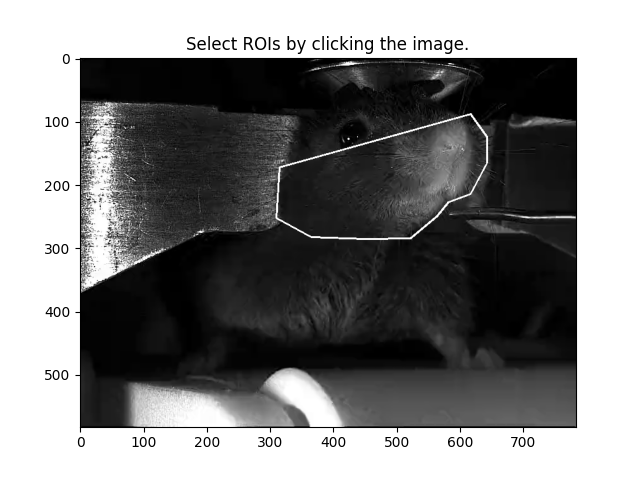

Button(description='Confirm ROI', style=ButtonStyle())

Button(description='New ROI', style=ButtonStyle())

In [12]:
exampleImage = data[0][0]
# %matplotlib notebook
rois = fr.rois.ROIs(
    select_mode='gui',
    exampleImage=exampleImage,
#     select_mode='file',
#     path_file=str(Path('/home/rich/Desktop/0322N_and_0322R/mouse_0322N__20230430/') / 'ROIs.h5'),
#     path_file=r'/home/rich/Desktop/ROIs_7.h5',
    verbose=2
)

Make a point grid out of the first ROI

In [13]:
rois.make_points(rois=rois[0], point_spacing=13) if rois.point_positions is None else None

Save the `ROIs` object in the 'analysis_files' project folder

In [14]:
rois.save_config(path_config=path_config, overwrite=True, verbose=1)
rois.save_run_info(path_config=path_config, overwrite=True, verbose=1)
rois.save_run_data(path_config=path_config, overwrite=True, verbose=1)

visualize the ROIs

<IPython.core.display.Javascript object>


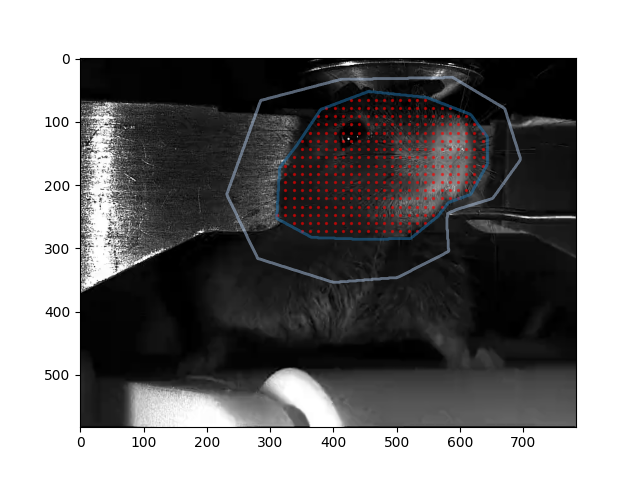

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [16]:
rois.plot_rois(exampleImage)

# Point Tracking

Prepare `PointTracker` object.\
Set `visualize_video` to **`True`** to tune parameters until they look appropriate, then set to **`False`** to run the full dataset through at a much faster speed.

Key parameters:
- `point_spacing`: distance between points. Vary so that total number of points is appropriate.
- `mesh_rigidity`: how rigid the mesh elasticity is. Vary so that points track well without drift.
- `relaxation`: how quickly the points relax back to their home position. Vary so that points track well without dift.
- `kwargs_method > winSize`: the spatial size of the optical flow calculation. Smaller is better but noisier, larger is less accurate but more robust to noise.
- `params_outlier_handling > threshold_displacement`: point displacements above this value will result in freezing of the points.

In [17]:
pt = fr.point_tracking.PointTracker(
    visualize_video=True,
#     buffered_video_reader=videos[:5],
    buffered_video_reader=videos,
    point_positions=rois.point_positions,
    rois_masks=[rois[1]],
    contiguous=True,
    params_optical_flow={
        "method": "lucas_kanade",
        "mesh_rigidity": 0.08,
        "mesh_n_neighbors": 40,
        "relaxation": 0.003,
        "kwargs_method": {
            "winSize": [40,40],
            "maxLevel": 2,
            "criteria": [cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 2, 0.03],
        },        
    },
    params_visualization={
        'alpha': 0.5,
        'point_sizes': 3,
    },
    params_outlier_handling = {
        'threshold_displacement': 150,  ## Maximum displacement between frames, in pixels.
        'framesHalted_before': 10,  ## Number of frames to halt tracking before a violation.
        'framesHalted_after': 10,  ## Number of frames to halt tracking after a violation.
    },
    verbose=2,
)

FR: 347 points will be tracked
FR: Collapsing mask ROI images into single mask
FR: Initializing mesh distances
FR: Preparing playback visualizer


Perform point tracking

In [18]:
pt.track_points()

FR: Setting initial frame_prev
FR: Iterating point tracking through videos



frame #: 100%|█████████████████████████████| 2000/2000 [00:18<00:00, 106.60it/s]

video #: 100%|████████████████████████████████████| 1/1 [00:18<00:00, 18.87s/it]

FR: Tracking complete
FR: Placing points_tracked into dictionary self.points_tracked where keys are video indices
FR: Placing violations into dictionary self.violations where keys are video indices


Save the `PointTracker` object in 'analysis_files' project directory.\
Using compression can reduce file sizes slightly but is very slow.

In [19]:
pt.save_config(path_config=path_config, overwrite=True, verbose=1)
pt.save_run_info(path_config=path_config, overwrite=True, verbose=2)
pt.save_run_data(path_config=path_config, overwrite=True, use_compression=False, verbose=1)

FR: Loading file /media/rich/bigSSD/test/run_info.json
FR: Adding 'PointTracker' field to run_info.json
FR: Saving run_info.json to /media/rich/bigSSD/test/run_info.json
FR WARNING: path_run_data file is expected to be named 'PointTracker.h5' if it is part of a project. Please make sure this is correct.


Clear some memory if needed. Optional.

In [20]:
pt.cleanup()

FR: Deleting all attributes


Load the `PointTracker` data as a dictionary

In [21]:
pt_data = fr.h5_handling.simple_load(str(Path(directory_project) / 'analysis_files' / 'PointTracker.h5'), return_dict=True, verbose=True)

==== Loading h5 file with hierarchy: ====
1. mask:            shape=(582, 784) ,  dtype=bool
2. mesh_d0:         shape=(347, 2) ,    dtype=float32
3. neighbors:       shape=(347, 40) ,   dtype=int64
4. point_positions:    shape=(347, 2) ,    dtype=float32
5. points_tracked:----------------
  1. 0:             shape=(2000, 347, 2) ,dtype=float32
6. violations:----------------
  1. 0:----------------
    1. row:         shape=(0,) ,        dtype=int32
    2. col:         shape=(0,) ,        dtype=int32
    3. data:        shape=(0,) ,        dtype=bool
    4. shape:       shape=(2,) ,        dtype=int64


# Spectral Analysis

Prepare `VQT_Analyzer` object.

Key parameters:
- `Q_lowF`:  Quality of the lowest frequency band of the spectrogram. Q value is number of oscillation periods.
- `Q_highF`: Quality of the highest frequency band...
- `F_min`: Lowest frequency band to use.
- `F_max`: Highest frequency band to use.
- `downsample_factor`: How much to downsample the spectrogram by in time.
- `return_complex`: Whether or not to return the complex spectrogram. Generally set to False unless you want to try something fancy.

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)


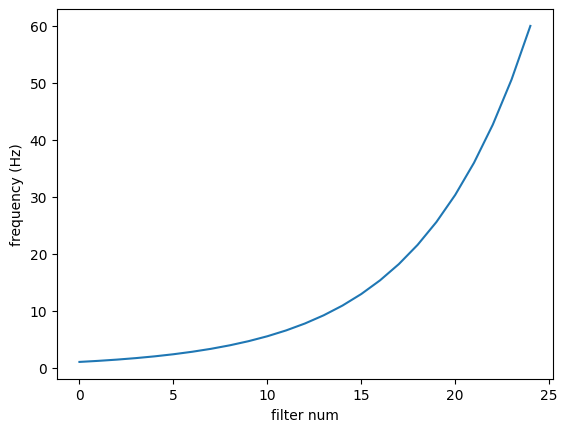

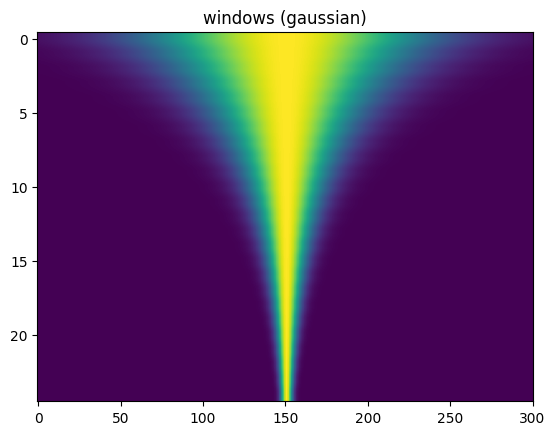

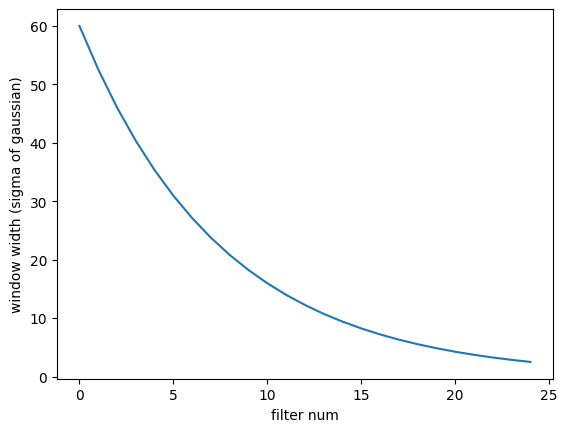

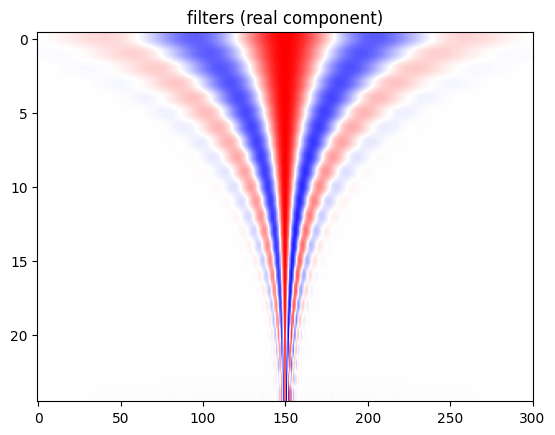

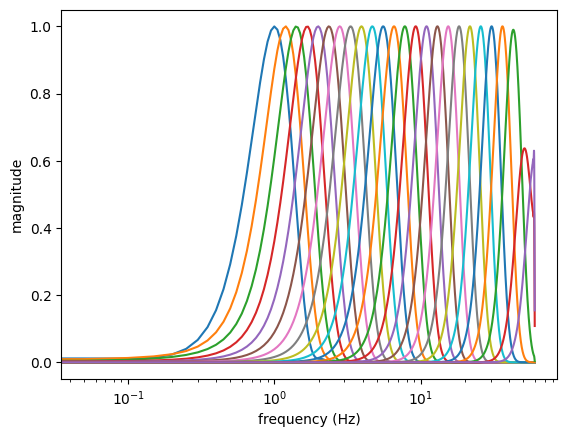

In [24]:
%matplotlib inline
Fs = fr.util.load_run_info_file(path_run_info)['Dataset_videos']['frame_rate']

spec = fr.spectral_analysis.VQT_Analyzer(
    params_VQT = {
        'Fs_sample': Fs, 
        'Q_lowF': 2, 
        'Q_highF': 5, 
        'F_min': 1.0, 
        'F_max': data.frame_rate//2, 
        'n_freq_bins': 25, 
        'win_size': 301, 
        'plot_pref': True, 
        'downsample_factor': 8, 
        'padding': 'valid',
        'DEVICE_compute': fr.helpers.set_device(use_GPU=True), 
        'batch_size': 10,
        'return_complex': False, 
        'progressBar': True,
    },
    normalization_factor=0.95,
    spectrogram_exponent=1.0,
    one_over_f_exponent=0.5,
    verbose = 2,
)

Look at a demo spectrogram of a single point.\
Specify the point with the `idx_point` and `name_points` fields.\
Note that the `pt_data['points_tracked']` dictionary holds subdictionaries withe numeric string names (ie `['0'], ['1']`) for each video.

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.55s/it]

Demo spectrogram shape: (2, 25, 213)


<IPython.core.display.Javascript object>


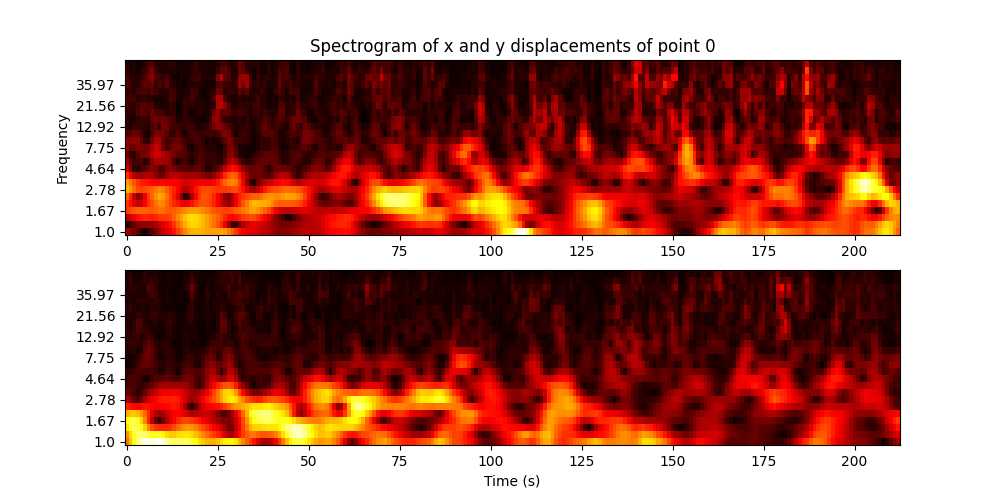

Total size of all spectrograms: 0.01735000 GB
Individual spectrogram sizes (in GB): [0.01735]


In [26]:
%matplotlib notebook
spec_demo, xAxis_demo, freqs_demo = spec.demo_transform(
    points_tracked=pt_data['points_tracked'],
    point_positions=pt_data['point_positions'],
    idx_point=0,
    name_points='0',
    plot=True,
);

Generate spectrograms

In [27]:
spec.transform_all(
    points_tracked=pt_data['points_tracked'],
    point_positions=pt_data['point_positions'],
)

Preparing traces. Reshaping and subtracting offsets...
Computing spectrograms...



Computing spectrograms: 100%|█████████████████████| 1/1 [00:00<00:00, 13.27it/s]


Save the `VQT_Analyzer` object in 'analysis_files' project directory.\
Using compression can reduce file sizes slightly but is very slow.

In [28]:
spec.save_config(path_config=path_config, overwrite=True, verbose=1)
spec.save_run_info(path_config=path_config, overwrite=True, verbose=1)
spec.save_run_data(path_config=path_config, overwrite=True, use_compression=False, verbose=1)

FR WARNING: path_run_data file is expected to be named 'VQT_Analyzer.h5' if it is part of a project. Please make sure this is correct.


Clear some memory if needed. Optional.

In [29]:
spec.cleanup()

FR: Deleting all attributes


Load the `VQT_Analyzer` data as a dictionary

In [30]:
spec_data = fr.h5_handling.simple_load(str(Path(directory_project) / 'analysis_files' / 'VQT_Analyzer.h5'), return_dict=True, verbose=True)

==== Loading h5 file with hierarchy: ====
1. VQT:----------------
  1. filters:       shape=(25, 301) ,   dtype=complex64
  2. wins:          shape=(25, 301) ,   dtype=float32
2. frequencies:     shape=(25,) ,       dtype=float32
3. point_positions:    shape=(694,) ,      dtype=float32
4. spectrograms:----------------
  1. 0:             shape=(2, 347, 25, 213) ,dtype=float32
5. x_axis:----------------
  1. 0:             shape=(213,) ,      dtype=float32


# Decomposition

Prepare `TCA` object, and then rearrange the data with the `.rearrange_data` method.

Key parameters for `.rearrange_data`:
- `names_dims_array`:  Enter the names of the dimensions of the spectrogram. Typically these are `'xy', 'points', 'frequency', 'time'`.
- `names_dims_concat_array`: Enter any dimensions you wish to concatenate along other dimensions. Typically we wish to concatenate the `'xy'` dimension along the `'points'` dimension, so we make a list containing that pair as a tuple: `[('xy', 'points')]`.
- `concat_complexDim`: If your input data are complex valued, then this can concatenate the complex dimension along another dimension.
- `name_dim_dictElements`: The `data` argument is expected to be a dictionary of dictionaries of arrays, where the inner dicts are trials or videos. This is the name of what those inner dicts are. Typically `'trials'`.

In [31]:
# spectrograms = spec_data['spectrograms']
spectrograms = {key: np.abs(val) for key,val in list(spec_data['spectrograms'].items())[:]}

tca = fr.decomposition.TCA(verbose=2)

tca.rearrange_data(
    data=spectrograms,
    names_dims_array = ['xy', 'points', 'frequency', 'time'],
    names_dims_concat_array = [('xy', 'points')],
    concat_complexDim=False,
    name_dim_concat_complexDim='time',
    name_dim_dictElements = 'session',
    method_handling_dictElements = 'separate',
    name_dim_concat_dictElements = 'time',
    idx_windows=None,
    name_dim_array_window='time',
)

Preparing new names for the concatenated array dimensions. From ['xy', 'points', 'frequency', 'time'] to ['(xy points)', 'frequency', 'time'].
Rearranging the dict elements using method 'separate'.


Optionally, you can normalize along a specified axis

In [32]:
tca.normalize_data(
    mean_subtract=False,
    std_divide=True, 
    dim_name='time', 
)

Fit TCA model.

There are a few methods that can be used:
- `'CP_NN_HALS'`: non-negative CP decomposition using the efficient HALS algorithm. This should be used in most cases.
- `'CP'`: Standard CP decomposition. Use if input data are not non-negative (if you are using complex valued spectrograms or similar).
- `'Randomized_CP'`: Randomized CP decomposition. Allows for large input tensors. If you are using huge tensors and you are memory constrained or want to run on a small GPU, this is your only option.

If you have and want to use a CUDA compatible GPU:
- Set `DEVICE` to `'cuda'`
- GPU memory can be saved by setting `'init'` method to `'random'`. However, fastest convergence and highest accuracy typically come from `'init': 'svd'`.

In [33]:
tca.fit(
    method='CP_NN_HALS',
#     method='CP',
    params_method={
        'rank': 10, 
        'n_iter_max': 1000, 
        'init': 'random', 
        'svd': 'truncated_svd', 
        'tol': 1e-09, 
#         'nn_modes': [0,1], 
        'verbose': True, 
    },
    DEVICE=fr.helpers.set_device(use_GPU=True),
    verbose=2,
)

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)
Using device: cuda:0
Using method: <class 'tensorly.decomposition._nn_cp.CP_NN_HALS'>
Running the TCA model with method 'CP_NN_HALS'.


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/FR/lib/python3.9/site-packages/tensorly/backend/pytorch_backend.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(


reconstruction error=0.5045143961906433
iteration 1, reconstruction error: 0.45770880579948425, decrease = 0.04680559039115906
iteration 2, reconstruction error: 0.4504767060279846, decrease = 0.007232099771499634
iteration 3, reconstruction error: 0.4470508396625519, decrease = 0.0034258663654327393
iteration 4, reconstruction error: 0.44527995586395264, decrease = 0.0017708837985992432
iteration 5, reconstruction error: 0.44416344165802, decrease = 0.0011165142059326172
iteration 6, reconstruction error: 0.44322067499160767, decrease = 0.0009427666664123535
iteration 7, reconstruction error: 0.44228506088256836, decrease = 0.0009356141090393066
iteration 8, reconstruction error: 0.44128286838531494, decrease = 0.001002192497253418
iteration 9, reconstruction error: 0.44021424651145935, decrease = 0.0010686218738555908
iteration 10, reconstruction error: 0.4391353130340576, decrease = 0.0010789334774017334
iteration 11, reconstruction error: 0.4381820857524872, decrease = 0.0009532272

iteration 93, reconstruction error: 0.434360533952713, decrease = 1.7881393432617188e-06
iteration 94, reconstruction error: 0.4343586266040802, decrease = 1.9073486328125e-06
iteration 95, reconstruction error: 0.43435704708099365, decrease = 1.5795230865478516e-06
iteration 96, reconstruction error: 0.43435606360435486, decrease = 9.834766387939453e-07
iteration 97, reconstruction error: 0.4343545138835907, decrease = 1.5497207641601562e-06
iteration 98, reconstruction error: 0.4343533217906952, decrease = 1.1920928955078125e-06
iteration 99, reconstruction error: 0.4343525767326355, decrease = 7.450580596923828e-07
iteration 100, reconstruction error: 0.4343515932559967, decrease = 9.834766387939453e-07
iteration 101, reconstruction error: 0.4343508183956146, decrease = 7.748603820800781e-07
iteration 102, reconstruction error: 0.4343498647212982, decrease = 9.5367431640625e-07
iteration 103, reconstruction error: 0.4343494474887848, decrease = 4.172325134277344e-07
iteration 104, r

Rearrange the factors.\
You can undo the concatenation that was done during `.rearrange_data`

In [34]:
tca.rearrange_factors(
    undo_concat_complexDim=False,
    undo_concat_dictElements=False,
)

Save the `TCA` object in 'analysis_files' project directory.

In [35]:
tca.save_config(path_config=path_config, overwrite=True, verbose=1)
tca.save_run_info(path_config=path_config, overwrite=True, verbose=1)
tca.save_run_data(path_config=path_config, overwrite=True, use_compression=False, verbose=1)

FR WARNING: path_run_data file is expected to be named 'TCA.h5' if it is part of a project. Please make sure this is correct.


Clear some memory if needed. Useful if you ran the fit on a GPU. Optional.

In [36]:
tca._cleanup()

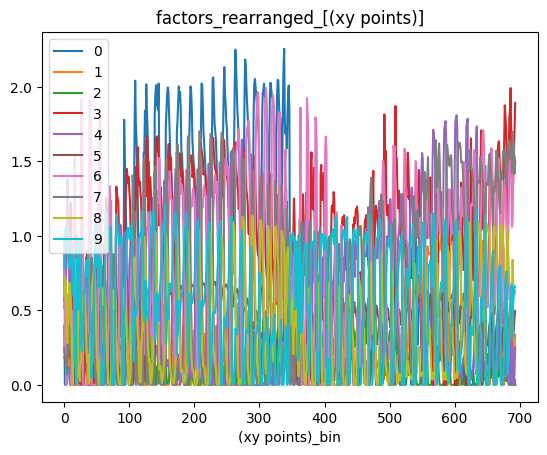

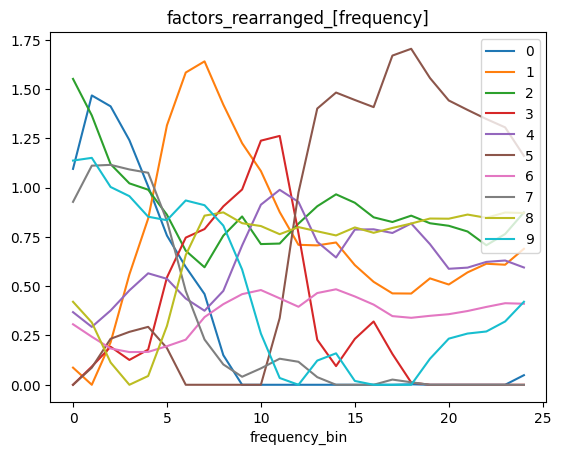

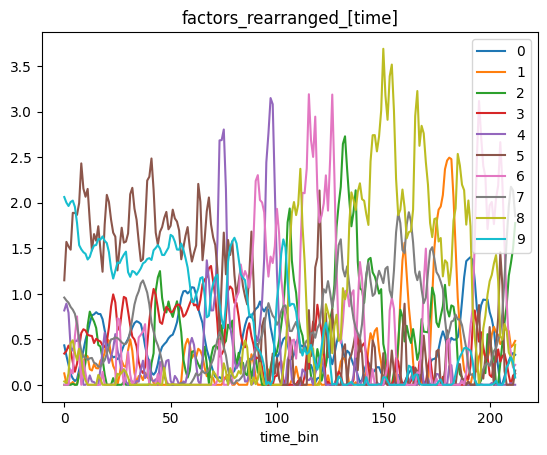

In [40]:
%matplotlib inline
tca.plot_factors(
    figure_saver=None,
    show_figures=True,
)

# Visualize results

In [41]:
import matplotlib.pyplot as plt

Load the `PointTracker`, `TCA`, and `VQT` data as dictionaries

In [42]:
tca_data  = fr.h5_handling.simple_load(str(Path(directory_project) / 'analysis_files' / 'TCA.h5'), return_dict=True)
spec_data = fr.h5_handling.simple_load(str(Path(directory_project) / 'analysis_files' / 'VQT_Analyzer.h5'), return_dict=True)
pt_data   = fr.h5_handling.simple_load(str(Path(directory_project) / 'analysis_files' / 'PointTracker.h5'), return_dict=True)

visualize the spectral factors and corresponding spatial factors

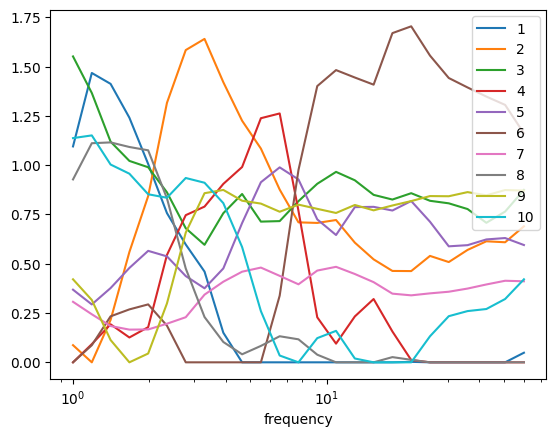

In [43]:
fig_tca_specFactor = plt.figure()
plt.plot(spec_data['frequencies'], tca_data['factors']['0']['frequency'])
plt.xscale('log')
plt.xlabel('frequency')
plt.legend(np.arange(tca_data['factors']['0']['frequency'].shape[1]) + 1);
plt.show()

Save figure

In [44]:
figure_saver.save_figure(
    fig=fig_tca_specFactor,
    name_save=f'fig_tca_specFactor',
)

visualize the point factor magnitudes


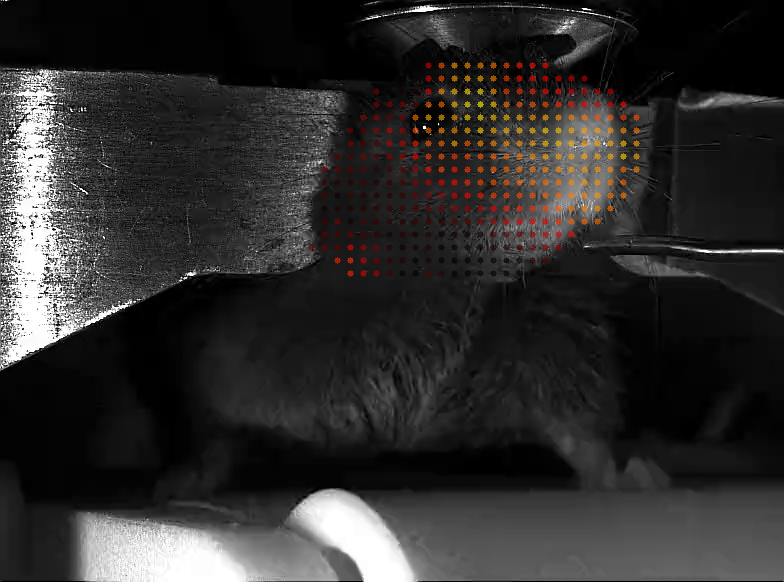

In [51]:
cmap = fr.helpers.simple_cmap(
    colors=[[0,0,0], [1,0,0], [1,1,0]], 
    over=[0,1,0], 
    under=[0,1,0], 
    bad=[0,1,0], 
)

factor_values = tca_data['factors_rearranged']['0']['(xy points)']
factor_magnitudes = np.linalg.norm(factor_values.reshape(2, factor_values.shape[0]//2, -1), axis=0)

pts_tmp = pt_data['point_positions']
im_tmp = videos.video_readers[0][0].cpu().numpy()

frame_visualizer = fr.visualization.FrameVisualizer(
    verbose=2,
    frame_height_width=videos.frame_height_width,
    point_sizes=3,
    alpha=0.6,
)

ims_factors_points = [frame_visualizer.visualize_image_with_points(image=im_tmp, points=pts_tmp, points_colors=[(cmap(f/f.max())*255).astype(np.int64)[:,:3]]) for f in factor_magnitudes.T] 

fr.visualization.display_toggle_image_stack(ims_factors_points)

### Save images

Prepare an image saving helper class. It can save individual images in multiple formats as well as a list of images as a GIF.

In [52]:
image_saver = fr.util.Image_Saver(
    path_config=path_config,
    dir_save=None,
    overwrite=True,
    verbose=1,
)

save individual factor images

In [53]:
[image_saver.save_image(
    array_image=im,
    name_save=f'im_factors_points_{ii+1}',
    formats_save=['png'],
) for ii, im in enumerate(ims_factors_points)];

save gif of all the images

In [54]:
image_saver.save_gif(
    array_images=fr.helpers.add_text_to_images(
        images=ims_factors_points,
        text=[[f'factor: {ii+1}'] for ii in range(len(ims_factors_points))],
        position=(10, 40),
        font_size=1,
        line_width=2,
        color=(255,255,255),
    ),
    name_save=f'im_factors_points',
    frame_rate=2.0,
    loop=0,
);

# Demo playback

Playback a video with points overlayed.\
Make sure you have a `BufferedVideoReader` object called `videos` made of your videos

In [66]:
idx_video_to_use = 0
idx_frames_to_use = np.arange(0, 1000)

videos.method_getitem = 'by_video'

frame_visualizer = fr.visualization.FrameVisualizer(
    display=True,
    error_checking=True,
    verbose=2,
    path_save=str(Path(directory_project) / 'visualizations' / 'point_tracking_demo.avi'),
#     path_save=None,
    frame_height_width=videos.frame_height_width,
    frame_rate=data.frame_rate,
    point_sizes=3,
    points_colors=(0,255,255),
#     points_colors=[(cmap((factor_magnitudes / factor_magnitudes.max(0)))*255)[:,:,:3].astype(int).transpose(1,0,2)[0]],
    alpha=0.6,
)

fr.visualization.play_video_with_points(
    bufferedVideoReader=videos[idx_video_to_use],
    frameVisualizer=frame_visualizer,
    points=list(pt_data['points_tracked'].values())[0],
    idx_frames=idx_frames_to_use,
)

Initializing video writer with frame_rate=120, fourcc="MJPG", frame_height_width=(582, 784), path_save=/media/rich/bigSSD/test/visualizations/point_tracking_demo.avi
<class 'face_rhythm.helpers.BufferedVideoReader'>


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 52.24it/s]
